# Adaptive Finite Element Methods

Adaptive methods are now widely used in the scientific computation to achieve better accuracy with minimum degree of freedom. We present an example here and refer to the lecture notes [Adaptive Finite Element Methods](https://www.math.uci.edu/~chenlong/226/Ch4AFEM.pdf) for convergence analysis.

Documentation on bisection and coarsening for 2D triangulation can be found below:
- [Bisection in Two Dimensions](bisectdoc.html)
- [Coarsen in Two Dimensions](coarsendoc.html)

## Singularity

In FEM, we have obtained a first order convergence of the linear finite element approximation to the Poisson equation

$$
-\Delta u = f \quad \text{in } \Omega, \qquad u=0 \quad \text{ on } \partial \Omega,
$$

provided the solution $u\in H^2(\Omega)$. Here is an example such regularity result does not hold. 

Let $\Omega:= (-1,1)^2 \backslash \{[0,1)\times(-1,0]\}$ be a L-shaped domain with a reentrant corner. Consider the equation

$$
-\Delta u = 0, \text{ in } \Omega  \quad \text{ and } \; 
u=g \text{ on } \partial \Omega,
$$

We choose the Dirichlet boundary condition $g$ such that the exact solution reads

$$u(r,\theta) = r^{\frac{2}{3}}\sin(\frac{2}{3}\theta),$$

in the polar coordinates. Then $u\in H^s$ for $s<5/3$.

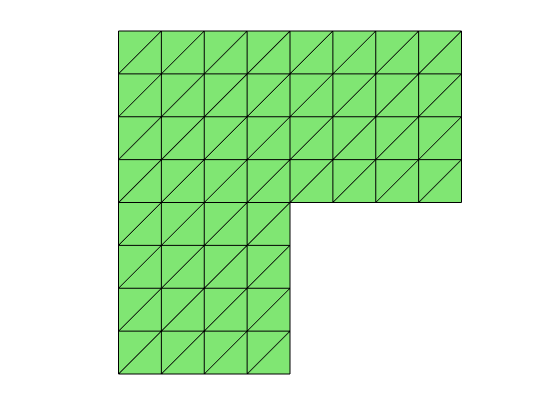

In [1]:
%%  Generate an initial mesh of the Lshape domain and set PDE data
[node,elem] = squaremesh([-1,1,-1,1],0.25);
[node,elem] = delmesh(node,elem,'x>0 & y<0');
bdFlag = setboundary(node,elem,'Dirichlet');
mesh = struct('node',node,'elem',elem,'bdFlag',bdFlag);
showmesh(node,elem);
pde = Lshapedata;

Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:     3201,  #nnz:    14473, smoothing: (1,1), iter:  9,   err = 7.57e-09,   time = 0.09 s
Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:    12545,  #nnz:    59657, smoothing: (1,1), iter: 10,   err = 1.35e-09,   time = 0.11 s

 #Dof       h        ||u-u_h||    ||Du-Du_h||   ||DuI-Du_h|| ||uI-u_h||_{max}

  225   7.143e-02   6.55149e-03   1.13956e-01   4.35355e-02   2.01109e-02
  833   3.589e-02   2.69513e-03   7.29268e-02   2.77815e-02   1.30302e-02
 3201   1.799e-02   1.09785e-03   4.64100e-02   1.75876e-02   8.29780e-03
12545   9.009e-03   4.43931e-04   2.94264e-02   1.11008e-02   5.24950e-03

 #Dof   Assemble     Solve      Error      Mesh    

  225   6.00e-02   1.00e-02   9.00e-02   2.00e-02
  833   3.00e-02   0.00e+00   2.00e-02   2.00e-02
 3201   7.00e-02   9.00e-02   4.00e-02   0.00e+00
12545   1.50e-01   1.10e-01   1.00e-01   6.00e-02




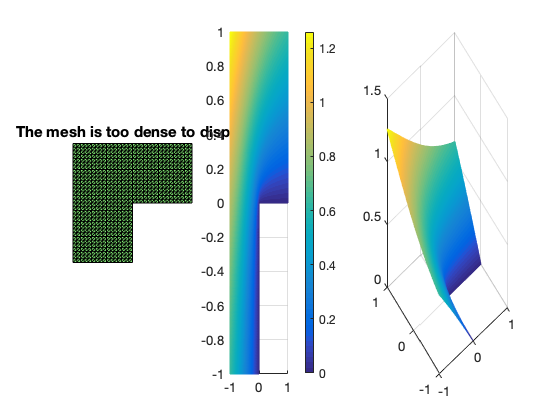

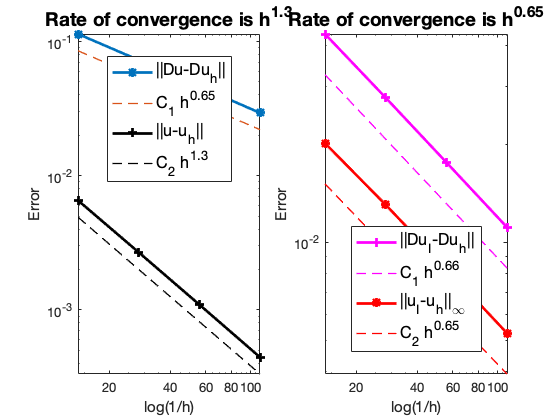

In [2]:
% Solve Poisson equation by the linear FEM
femPoisson(mesh,pde);

When $u\in H^{1+\epsilon}(\Omega)$ with $\epsilon \in [0,1]$, in view of the approximation theory, we cannot expect the finite element
approximation rate $\|\nabla (u-u_h)\|$ better than $h^{\epsilon}$ if we insist on quasi-uniform grids. For the Lshape problem above, we expect the rate of convergence is less than $2/3 \approx 0.67$ which is confirmed by the numerical example.

## Adaptive Procedure

Standard adaptive finite element methods (AFEM) based on the local mesh refinement can be written as loops of the form

**SOLVE -> ESTIMATE -> MARK -> REFINE**

Starting from an initial triangulation $\mathcal  T_0$, to get $\mathcal T_{k+1}$ from $\mathcal T_k$ we first solve the equation to get $u_k$ based on $\mathcal T_k$. The error is estimated using $u_k$ and $\mathcal  T_k$ and used to mark a set of of triangles in $\mathcal T_k$. Marked triangles and possible more neighboring triangles are refined in such a way that the triangulation is still shape regular and conforming. 

Example: `Lshape.m`

Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:     2231,  #nnz:    10757, smoothing: (1,1), iter:  7,   err = 4.05e-10,   time = 0.14 s
Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:     2860,  #nnz:    13804, smoothing: (1,1), iter:  7,   err = 3.24e-10,   time = 0.04 s
Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:     3631,  #nnz:    17541, smoothing: (1,1), iter:  7,   err = 4.38e-10,   time = 0.07 s
Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:     4585,  #nnz:    22285, smoothing: (1,1), iter:  7,   err = 4.78e-10,   time = 0.05 s
Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:     5785,  #nnz:    28297, smoothing: (1,1), iter:  7,   err = 4.25e-10,   time = 0.05 s
Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:     7278,  #nnz:    35678, smoothing: (1,1), iter:  7,   err = 4.25e-10,   time = 0.07 s
Multigrid V-cycle Preconditioner with Conjugat

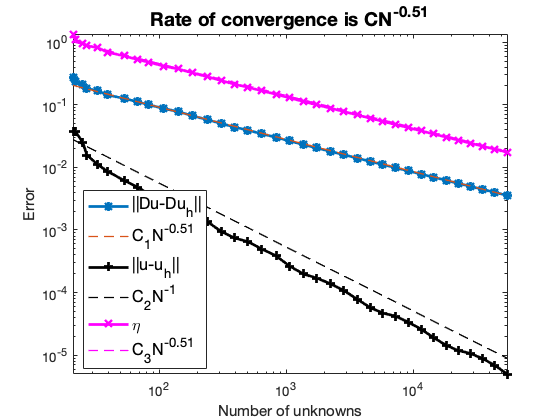

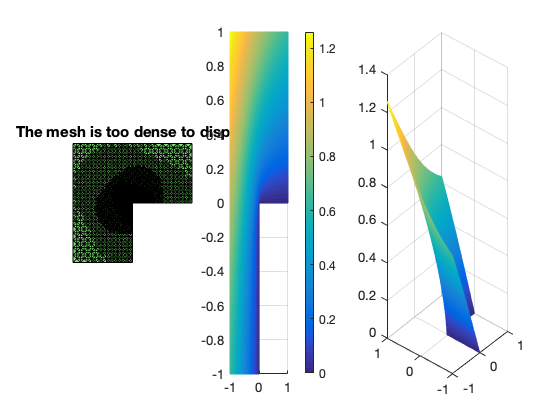

In [3]:
%% Parameters
maxN = 5e4;     theta = 0.4;    maxIt = 100; 
N = zeros(maxIt,1);   
errL2 = zeros(maxIt,1);   
errH1 = zeros(maxIt,1); 
erreta = zeros(maxIt,1);

%%  Generate an initial mesh and set up PDE data
[node,elem] = squaremesh([-1,1,-1,1],0.5);
[node,elem] = delmesh(node,elem,'x>0 & y<0');
bdFlag = setboundary(node,elem,'Dirichlet');
pde = Lshapedata;

%%  Adaptive Finite Element Method
% *SOLVE* -> *ESTIMATE* -> *MARK* -> *REFINE*
for k = 1:maxIt
    % Step 1: SOLVE
    [soln,eqn,info] = Poisson(node,elem,bdFlag,pde);
    figure(1);  showresult(node,elem,soln.u,[-50,12]);    
    % Step 2: ESTIMATE
%     eta = estimaterecovery(node,elem,u);         % recovery type
    eta = estimateresidual(node,elem,soln.u,pde);    % residual type
    % Record error and number of vertices
    N(k) = size(node,1);
    errH1(k) = getH1error(node,elem,pde.Du,soln.Du);
    errL2(k) = getL2error(node,elem,pde.exactu,soln.u);
    erreta(k) = sqrt(sum(eta.^2));
    if (N(k)>maxN), break; end        
    % Step 3: MARK
    markedElem = mark(elem,eta,theta);
    % Step 4: REFINE
    [node,elem,bdFlag] = bisect(node,elem,markedElem,bdFlag);
end

%% Plot convergence rates
figure;
showrate3(N(1:k),errH1(1:k),10,'-*','||Du-Du_h||',...
          N(1:k),errL2(1:k),10,'k-+','||u-u_h||',...
          N(1:k),erreta(1:k),10,'m-x','\eta');

The solution has a sharp gradient near the origin and the adaptive FEM automatically refines the mesh near the singularity. Optimal rate of convergence in terms of number of unknowns, i.e., 

$$\|\nabla (u - u_h) \|\leq C N^{-0.5}$$ 

is observed. For quasi-uniform meshes in 2D, $N^{-0.5} \approx h$ is first order. The *a posteriori* error estimator $\eta$ is an upper bound of the error and always decay in an optimal order. The $L^2$-norm of the error converges in second order.

## Details of Each Step

- **SOLVE**. We use direct solver `A\b` or multigrid solvers to solve the linear system `Au=b`. For meshes generated in `ifem`, `mg(A,b,elem)` is faster than `amg(A,b)`.

- **ESTIMATE**. We use the residual-type a posterior error estimator `estimateresidual` which returns 
$$
\eta(\tau,u_{\mathcal T})^2 = \|h f\|_{0,\tau}^2 + \sum _{e\in \partial \tau} \|h^{1/2}[\nabla u_{\mathcal T}\cdot n_e]\|_{0,e}^2.
$$
Other option is `estimaterecovery(node,elem,u)` which only requres the mesh and a finite element function. Recovery type estimator is more flexiable but residual-type is more theoretical sound. 

- **MARK**. Let $\theta \in (0,1)$. We use the bulk marking strategy 

$$
\eta ^2(u_{\mathcal T},\mathcal M_{\mathcal T})\geq \theta \, \eta ^2(u_{\mathcal T},\mathcal T).
$$

Use `markedElem = mark(elem,eta,theta,'max')` for the maximum marking strategy
$$
\eta (u_{\mathcal T},\tau ^*)\geq \theta \max _{\tau\in \mathcal T}\eta (u_{\mathcal T},\tau ).
$$

- **REFINE**. We implement the newest vertex bisection and refer to [Bisection in Two Dimensions](bisectdoc.html) for detailed description.In short, the bisection method will divide one triangle into two children triangles by connecting one vertex to the middle point of its opposite edge. The subtlity is to keep both thehape regularity and conformity of the mesh. 

- **COARSEN**. For some problems, e.g., evolution problems, coarsening (de-refinement) is needed as the singularity could move. Then use
        eta = eleminterpolate(eta,tree);
        markedElem = mark(elem,eta,0.5*theta,'COARSEN');
        [node,elem,bdFlag] = coarsen(node,elem,markedElem,bdFlag);
        
See [Coarsen in two dimensions](coarsendoc.html) for the coarsening algorithm.